In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from ipywidgets import interact
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from finta import TA
from sklearn.model_selection import TimeSeriesSplit,cross_val_score,cross_validate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#import yahoofinancials
import matplotlib.pyplot as plt
import numpy as np
#from hyperopt import hp
from numpy import mean
from numpy import std
from numpy import dstack
#from pandas import read_csv
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from tensorflow.keras.layers import GaussianNoise,Activation,Dense,Conv1D,MaxPooling1D,Input,Dropout,BatchNormalization,Flatten,LeakyReLU,Dropout

import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Num GPUs Available:  1
GPU is available


In [2]:
#!pip install yfinance finta
#import keras 
tf.__version__

'2.2.0'

In [3]:
data=yf.Ticker('MXN=X')
data=data.history(period="max")
data=data.loc["2000-01-20":"2020-12-31"][["Open","High","Low",'Close']]
data.tail()

,Open,High,Low,Close
Date,,,,
2020-09-01,21.9097,21.9104,21.6744,21.9125
2020-09-02,21.7450,21.8895,21.7373,21.7453
2020-09-03,21.7356,21.7930,21.5441,21.7269
2020-09-04,21.7043,21.7131,21.4926,21.6987
2020-09-07,21.5547,21.6591,21.5017,21.6026


In [4]:
sp=yf.Ticker('SPY')
sp=sp.history(period="max")
sp=sp.loc["2000-01-20":"2020-12-31"][["Open","High","Low",'Close']]
sp.tail()

,Open,High,Low,Close
Date,,,,
2020-08-31,350.35,351.30,349.06,349.31
2020-09-01,350.21,352.71,349.24,352.60
2020-09-02,354.67,358.75,353.43,357.70
2020-09-03,355.87,356.38,342.59,345.39
2020-09-04,346.13,347.83,334.88,342.57


In [5]:
data=data.join(sp,how="left",rsuffix="sp")

In [6]:
data["sp_percent_change"] = data["Closesp"].pct_change(periods=1).astype(float)
#data = data.merge(SP["sp_percent_change"], left_index=True, right_index=True,how="left")
data["percent_change"] = data["Close"].pct_change(periods=1).astype(float)
# Daily percent change as compared to the S&P 500
data["relative_change"] = data["percent_change"] - data["sp_percent_change"]
data.tail()

,Open,High,Low,Close,Opensp,Highsp,Lowsp,Closesp,sp_percent_change,percent_change,relative_change
Date,,,,,,,,,,,
2020-09-01,21.9097,21.9104,21.6744,21.9125,350.21,352.71,349.24,352.60,0.009419,0.007476,-0.001943
2020-09-02,21.7450,21.8895,21.7373,21.7453,354.67,358.75,353.43,357.70,0.014464,-0.007630,-0.022094
2020-09-03,21.7356,21.7930,21.5441,21.7269,355.87,356.38,342.59,345.39,-0.034414,-0.000846,0.033568
2020-09-04,21.7043,21.7131,21.4926,21.6987,346.13,347.83,334.88,342.57,-0.008165,-0.001298,0.006867
2020-09-07,21.5547,21.6591,21.5017,21.6026,NaN,NaN,NaN,NaN,0.000000,-0.004429,-0.004429


In [7]:
data.columns=data.columns.str.lower()

In [8]:
def add_indicators(data):
        # This is a list of all possible indicators we can use
        # indicators = ['ADL', 'ADX', 'AO', 'APZ', 'ATR',
        # 'BASP', 'BASPN', 'BBANDS', 'BBWIDTH', 'CCI', 'CFI', 'CHAIKIN', 'CHANDELIER', 'CMO', 'COPP', 'DEMA', 'DMI',
        # 'DO', 'EBBP', 'EFI', 'EMA', 'EMV', 'ER', 'EVWMA', 'EV_MACD', 'FISH', 'FVE', 'HMA', 'ICHIMOKU', 'IFT_RSI',
        # 'KAMA', 'KC', 'KST', 'MACD', 'MFI', 'MI', 'MOM', 'MSD', 'OBV', 'PERCENT_B', 'PIVOT', 'PIVOT_FIB', 'PPO',
        # 'PZO', 'QSTICK', 'ROC', 'RSI', 'SAR', 'SMA', 'SMM', 'SMMA', 'SQZMI', 'SSMA', 'STC', 'STOCH', 'STOCHD',
        # 'STOCHRSI', 'TEMA', 'TMF', 'TP', 'TR', 'TRIMA', 'TRIX', 'TSI', 'UO', 'VAMA', 'VFI', 'VORTEX', 'VPT', 'VR',
        # 'VWAP', 'VW_MACD', 'VZO', 'WILLIAMS', 'WMA', 'WOBV', 'WTO', 'ZLEMA']

        # Here are all indicators we are using
    indicators = ['SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'ER', 'KAMA', 'ZLEMA',
                      'WMA', 'HMA', 'SMMA', 'MACD', 'PPO', 'MOM', 'ROC', 'RSI',
                      'IFT_RSI']
        # These indicators need more tuning or are broken
    broken_indicators = ['SAR', 'TMF', 'QSTICK']
    for indicator in indicators:
        if indicator not in broken_indicators:
            df = None
                # Using python's eval function to create a method from a string instead of having every method defined
            df = eval('TA.' + indicator + '(data)')
                # Some method return series, so we can check to convert here
            if not isinstance(df, pd.DataFrame):
                df = df.to_frame()
                # Appropriate labels on each column
            df = df.add_prefix(indicator + '_')
                # Join merge dataframes based on the date
            data = data.merge(df, left_index=True, right_index=True)
        # Fix labels
    data.columns = data.columns.str.replace(' ', '_')
    return(data)

In [9]:
data=add_indicators(data)

In [10]:
data.dropna(inplace=True)

In [11]:
data["dir"]=np.sign(data["percent_change"]).shift(-1)
data.dropna(inplace=True)
data["dir"]=data["dir"].apply(lambda x: 1 if x>=0 else 0)
data["dir_ant30"]=data["dir"].rolling(window=30).mean()
data.dropna(inplace=True)

In [12]:
data.tail(7)

,open,high,low,close,opensp,highsp,lowsp,closesp,sp_percent_change,percent_change,...,MACD_SIGNAL,PPO_PPO,PPO_SIGNAL,PPO_HISTO,MOM_MOM,ROC_ROC,RSI_14_period_RSI,IFT_RSI_IFT_RSI,dir,dir_ant30
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-26,21.9104,21.9799,21.8673,21.8947,344.76,347.86,344.17,347.57,0.010026,-0.003563,...,-0.085680,-0.519971,-0.384710,-0.135262,-0.5167,-2.275872,38.888690,17.706710,1,0.533333
2020-08-27,21.9314,22.1787,21.8297,21.9309,348.51,349.90,346.53,348.33,0.002187,0.001653,...,-0.092642,-0.542874,-0.416343,-0.126531,-0.4100,-2.343134,40.351840,14.795580,1,0.533333
2020-08-28,22.1369,22.1539,21.8231,22.1329,349.44,350.72,348.15,350.58,0.006459,0.009211,...,-0.095494,-0.481740,-0.429422,-0.052318,-0.0210,-1.242671,47.854443,27.782890,0,0.500000
2020-08-31,21.7512,21.9304,21.7312,21.7499,350.35,351.30,349.06,349.31,-0.003623,-0.017305,...,-0.101512,-0.566784,-0.456895,-0.109890,-0.1836,-2.645372,38.075487,15.983015,1,0.533333
2020-09-01,21.9097,21.9104,21.6744,21.9125,350.21,352.71,349.24,352.60,0.009419,0.007476,...,-0.106375,-0.568326,-0.479181,-0.089145,-0.2297,-1.089650,43.366626,17.671054,0,0.533333
2020-09-02,21.7450,21.8895,21.7373,21.7453,354.67,358.75,353.43,357.70,0.014464,-0.007630,...,-0.112683,-0.623760,-0.508097,-0.115663,-0.3860,-0.858048,39.617941,14.099371,0,0.500000
2020-09-03,21.7356,21.7930,21.5441,21.7269,355.87,356.38,342.59,345.39,-0.034414,-0.000846,...,-0.119603,-0.666990,-0.539875,-0.127115,-0.4479,-1.875604,39.216192,11.916547,0,0.466667


In [13]:
X = data.drop('dir', axis=1).values
y = data['dir'].values

# Reshaping CNN




In [14]:
window=15
forecast=1
xx=[]
yy=[]
for i in range(len(X)-window+1):
  xx.append(X[i:i+window].reshape(window,X.shape[1]))
  yy.append(y[i+window-1])

xx=np.array(xx)
yy=np.array(yy)  

In [15]:
xx[-1,-1],yy[-1]

(array([ 2.17356000e+01,  2.17930000e+01,  2.15441000e+01,  2.17269000e+01,
         3.55870000e+02,  3.56380000e+02,  3.42590000e+02,  3.45390000e+02,
        -3.44143137e-02, -8.46159860e-04,  3.35681538e-02,  2.22293220e+01,
         2.19125000e+01,  2.19959926e+01,  2.18904738e+01,  2.17639196e+01,
         2.17389933e+01,  2.22267651e+01, -6.11627089e-02,  3.50991302e-01,
         2.20600405e+01,  2.18355089e+01,  2.18526511e+01,  2.17600787e+01,
         2.18041671e+01,  2.22889054e+01, -1.47284280e-01, -1.19603053e-01,
        -6.66990255e-01, -5.39875382e-01, -1.27114873e-01, -4.47900000e-01,
        -1.87560405e+00,  3.92161923e+01,  1.19165467e+01,  4.66666667e-01]),
 0)

In [16]:
data.iloc[-5:]

,open,high,low,close,opensp,highsp,lowsp,closesp,sp_percent_change,percent_change,...,MACD_SIGNAL,PPO_PPO,PPO_SIGNAL,PPO_HISTO,MOM_MOM,ROC_ROC,RSI_14_period_RSI,IFT_RSI_IFT_RSI,dir,dir_ant30
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-28,22.1369,22.1539,21.8231,22.1329,349.44,350.72,348.15,350.58,0.006459,0.009211,...,-0.095494,-0.481740,-0.429422,-0.052318,-0.0210,-1.242671,47.854443,27.782890,0,0.500000
2020-08-31,21.7512,21.9304,21.7312,21.7499,350.35,351.30,349.06,349.31,-0.003623,-0.017305,...,-0.101512,-0.566784,-0.456895,-0.109890,-0.1836,-2.645372,38.075487,15.983015,1,0.533333
2020-09-01,21.9097,21.9104,21.6744,21.9125,350.21,352.71,349.24,352.60,0.009419,0.007476,...,-0.106375,-0.568326,-0.479181,-0.089145,-0.2297,-1.089650,43.366626,17.671054,0,0.533333
2020-09-02,21.7450,21.8895,21.7373,21.7453,354.67,358.75,353.43,357.70,0.014464,-0.007630,...,-0.112683,-0.623760,-0.508097,-0.115663,-0.3860,-0.858048,39.617941,14.099371,0,0.500000
2020-09-03,21.7356,21.7930,21.5441,21.7269,355.87,356.38,342.59,345.39,-0.034414,-0.000846,...,-0.119603,-0.666990,-0.539875,-0.127115,-0.4479,-1.875604,39.216192,11.916547,0,0.466667


In [17]:
xx.shape

(4132, 15, 36)

# Bayesian Convolutional Neural Networks with Bayes by Backprop

https://medium.com/neuralspace/bayesian-convolutional-neural-networks-with-bayes-by-backprop-c84dcaaf086e

As you might guess, this could become a bit tricky in CNNs, because we basically do not only deal with weights standing alone how we do in feedforward neural networks, we deal here with filters which can be seen as collections of weights forming a new entity. But, we still place probability distributions over weights in these filters. Below, I plot left a CNN with single point-estimates as weights, and right a CNN with probability distributions over weights to give you a sense of comparison.

![texto alternativo](https://miro.medium.com/max/1050/1*_OKFNjh-GUl0Kl4cND5Djw.png)

As you might know, many CNNs consist of filter layers which build feature maps, pooling layers, and fully-connected layers to do a final classification. See the graph below for a basic illustration.

![texto alternativo](https://miro.medium.com/max/1050/1*YbhsI3gnbJTC79hmKiFiZA.png)

**Local reparameterisation trick for convolutional layers**

Recap all what was necessary to apply backpropagation to a feedforward neural network with probability distributions over weights: defining a variational distribution q, sampling from it, and applying the local reparameterisation trick. We do this in a slightly truncated manner for CNNs: we do not sample the weights w, but we sample instead layer activations b due to its consequent computational acceleration. The variational posterior probability distribution.

![texto alternativo](https://miro.medium.com/max/1050/1*0PD7WDjoAWlK2Rzzl8dIiw.png)

(where i and j are the input, respectively output layers, h and w the height, respectively width of any given filter) allows to implement the local reparameterisation trick in convolutional layers. Note our new definition αμ² of the variance of a Gaussian distribution. We multiply a scaling factor α with the mean μ, to the power of 2. This results in the subsequent equation for convolutional layer activations b:

![texto alternativo](https://miro.medium.com/max/1050/1*itlJPEh1zsE21kM-WWzu6g.png)

where ϵj ∼ N(0, 1), Ai is the receptive field, ∗ signalises the convolutional operation, and ʘ the component-wise multiplication.



**Applying two convolutional operations for mean and variance**

The crux of equipping a CNN with probability distributions over weights instead of single point-estimates and being able to update the variational posterior probability distribution q by backpropagation lies in applying two convolutional operations whereas filters with single point-estimates apply one. Since the output b is a function of mean μ and variance αμ² among others, we are then able to compute these two variables determining a Gaussian probability distribution separately.
We do this in two convolutional operations: in the first, we treat the output b as an output of a CNN updated by frequentist inference. We optimise with Adam towards a single point-estimate which makes the validation accuracy of classifications increasing. We interpret this single point-estimate as the mean μ of the variational posterior probability distributions q. In the second convolutional operation, we learn the variance αμ². As this formulation of the variance includes the mean μ, only α needs to be learned here. In this way, we ensure that only one parameter is updated per convolutional operation, exactly how it would have been with a CNN updated by frequentist inference.
In other words, while we learn in the first convolutional operation the maximum-a-posteriori (MAP) of the variational posterior probability distribution q, we observe in the second convolutional operation how much values for weights w deviate from this MAP. This procedure is repeated in the fully-connected layers.

In [18]:
split=int(xx.shape[0]*.8)
xx_train,xx_test,yy_train,yy_test=xx[:split],xx[split:],yy[:split],yy[split:]

In [19]:
import tensorflow_probability as tfp

In [20]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import layers#Convolution2DReparameterization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GaussianNoise
tfp.__version__

Instructions for updating:
non-resource variables are not supported in the long term


'0.10.0'

# Modelo Probabilístico

In [21]:
tfd = tfp.distributions
yy_tr=yy_train.reshape(-1,1)
yy_ts=yy_test.reshape(-1,1)

### Función de costo

In [22]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

## Bayes by Backprop

https://medium.com/neuralspace/probabilistic-deep-learning-bayes-by-backprop-c4a3de0d9743

Blundell, et al. (2015) introduced Bayes by Backprop that will most likely be seen as a break-through in probabilistic deep learning in some time. It symbolises a practical solution how the issue of the aforementioned intractability can be adequately solved.
Our subsequent process is underpinned by suggestions of Graves (2011) and Hinton and Van Camp (1993), based on the speed of computation, to use a variational rather than a Monte Carlo scheme to find the approximate Bayesian posterior distribution. First of all, that means we define a simplified approximate distribution q with its variational parameters θ that shall be as similar as possible to the underlying true distribution p that is intractible:

![texto alternativo](KL1.png)

This is realised by minimising the Kullback-Leibler (KL) divergence between p and q, what can be seen as an optimisation problem:

![texto alternativo](KL2.png)

A well-explaining graphical intuition for this procedure is given by Graves (2011):

![texto alternativo](KL3.gif)

So, let’s now look further into the KL-divergence and how it is defined:

![texto alternativo](KL4.png)

And here we face another pity: we have another integral and this symbolises another intractability. So, what to do now? We approximate again. We already have approximated the underlying true distribution p with a variational distribution q and we know that we can always sample, i.e. use Monte Carlo methods, from any intractable distribution. So, why do we not sample from the variational distribution q when we see tiny pieces of the true distribution p what happens while we see data? This exact step is the quintessence of Bayes by Backprop: first, we approximate the underlying true distribution p with an approximate distribution q which shape is represented by parameters θ that can be learnt, and second sample from that q while seeing data.

![texto alternativo](KL5.png)

![texto alternativo](KL6.png)

**Local Reparamerisation Trick**

Let us once again remember that we want to implement the above procedure in a neural network, and therefore must calculate derivatives of the parameters being learnt, i.e. for us, derivatives of distributions. For doing so, the local reparameterisation trick (Kingma et al., 2015) is deployed which “moves” the parameters to be learnt, namely the mean µ and the standard deviation σ in case of a Gaussian distribution, out of the distribution function for any weight w. We define that ϵ as a sample of a standard Gaussian distribution, multiply it with the standard deviation σ and add the mean µ.

![texto alternativo](KL7.png)

Doing so, we have these two parameters of interest incorporated in every weight value and can both calculate the derivative of it and re-write it into a probability distribution.
Our parameters are then updated, i.e. learnt, according to:

![texto alternativo](KL8.png)

### función de divergencia KL

Entendiendo que KL es la métrica que compara las distribuciones aposteriori $q_{\theta}(w|D)$ y $p(w|D)$ del tal modo que para cada peso se busca minimizar esta métrica. 

**State of Art**

Lo que hacen los layers Flipout es construir la distribución $q$ para cada $\theta$ dentro de la neurona...

Text(0.4, -0.6, '$p \\sim \\mathcal{N}(\\mu^{real},\\sigma^{real})$ real')

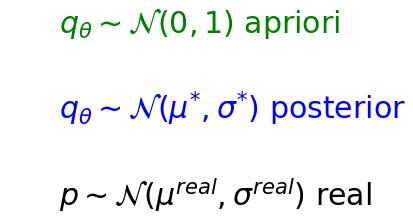

In [23]:
a = r'q_{\theta} \sim \mathcal{N}(0,1)'
b = r'q_{\theta} \sim \mathcal{N}(\mu^{*},\sigma^{*})'
c = r'p \sim \mathcal{N}(\mu^{real},\sigma^{real})'
ax = plt.axes([0,0,0.3,0.3]) #left,bottom,width,height
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.text(0.4,1.4,'$%s$ apriori' %a,size=30,color="g")
plt.text(0.4,0.4,'$%s$ posterior' %b,size=30,color="b")
plt.text(0.4,-0.6,'$%s$ real' %c,size=30,color="black")

Supongamos que $q_{\theta} \sim \mathcal{N}(.1076,.04896)$ y que $p \sim \mathcal{N}(.15,.06)$ entonces:

In [24]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [25]:
from scipy.stats import norm


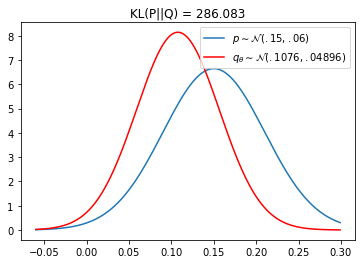

In [26]:
x = np.arange(-.06, .3, 0.001)
p = norm.pdf(x, .15,.06)
q = norm.pdf(x, .1076,.04896)
plt.title('KL(P||Q) = %1.3f' % kl_divergence(q, p))
plt.plot(x, p,label=r"$p \sim \mathcal{N}(.15,.06)$")
plt.plot(x, q, c='red',label=r"$q_{\theta} \sim \mathcal{N}(.1076,.04896)$")
plt.legend()

In [27]:
def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [28]:
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

## Modelo keras Bayeasiano 

In [29]:
inp=Input(shape=(xx_train.shape[1],xx_train.shape[2],))
x=BatchNormalization()(inp)
x=GaussianNoise(.1)(x)
#x=BatchNormalization()(x)
xconv1=tfp.layers.Convolution1DFlipout(128, 10, padding="same",activation=LeakyReLU(.1))
xconv1=add_kl_weight(xconv1,450)
x=xconv1(x)
x=BatchNormalization()(x)
#x=Conv1D(64,10,activation=LeakyReLU(.1),kernel_regularizer=l2(.1))(x)
#x=BatchNormalization()(x)
#x=Conv1D(32,10,activation=LeakyReLU(.1),kernel_regularizer=l2(.1))(x)
#x=BatchNormalization()(x)
#x=Dropout(.5)(x)
x=MaxPooling1D(10,padding="same")(x)
x=Flatten()(x)
x=BatchNormalization()(x)
xdense1=tfp.layers.DenseFlipout(200,activation="tanh")
xdense1=add_kl_weight(xdense1,450)
x=xdense1(x)
x=BatchNormalization()(x)
xdense2=tfp.layers.DenseFlipout(2,activation="softmax")
xdense2=add_kl_weight(xdense2,450)
x=xdense2(x)
model=Model(inp,x)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 36)]          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 36)            144       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 15, 36)            0         
_________________________________________________________________
conv1d_flipout (Conv1DFlipou (None, 15, 128)           92289     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 

In [30]:
model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(1e-3), metrics=['accuracy'],
                   experimental_run_tf_function=False)

In [31]:
#clear_session()
filepath="comun.hdf5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,es]
model.fit(xx_train, to_categorical(yy_train), batch_size=450, epochs=500, verbose=1, validation_data=(xx_test,to_categorical(yy_test)))

Train on 3305 samples, validate on 827 samples
Epoch 1/500
3305/3305 [==============================] - 1s 173us/sample - loss: 549.4046 - acc: 0.4995 - val_loss: 548.3477 - val_acc: 0.5091
Epoch 2/500
3305/3305 [==============================] - 0s 58us/sample - loss: 547.6561 - acc: 0.4902 - val_loss: 546.6120 - val_acc: 0.5115
Epoch 3/500
3305/3305 [==============================] - 0s 59us/sample - loss: 545.9201 - acc: 0.5062 - val_loss: 544.8954 - val_acc: 0.4970
Epoch 4/500
3305/3305 [==============================] - 0s 59us/sample - loss: 544.1745 - acc: 0.5283 - val_loss: 543.1423 - val_acc: 0.5103
Epoch 5/500
3305/3305 [==============================] - 0s 59us/sample - loss: 542.4491 - acc: 0.5349 - val_loss: 541.4432 - val_acc: 0.4788
Epoch 6/500
3305/3305 [==============================] - 0s 58us/sample - loss: 540.7216 - acc: 0.5449 - val_loss: 539.7307 - val_acc: 0.4909
Epoch 7/500
3305/3305 [==============================] - 0s 59us/sample - loss: 539.0020 - acc: 0.53

3305/3305 [==============================] - 0s 59us/sample - loss: 453.1920 - acc: 0.5625 - val_loss: 452.2713 - val_acc: 0.5030
Epoch 59/500
3305/3305 [==============================] - 0s 59us/sample - loss: 451.5534 - acc: 0.5516 - val_loss: 450.6359 - val_acc: 0.4667
Epoch 60/500
3305/3305 [==============================] - 0s 59us/sample - loss: 449.8952 - acc: 0.5576 - val_loss: 448.9665 - val_acc: 0.5151
Epoch 61/500
3305/3305 [==============================] - 0s 59us/sample - loss: 448.2415 - acc: 0.5631 - val_loss: 447.2903 - val_acc: 0.5260
Epoch 62/500
3305/3305 [==============================] - 0s 59us/sample - loss: 446.5891 - acc: 0.5722 - val_loss: 445.6884 - val_acc: 0.4958
Epoch 63/500
3305/3305 [==============================] - 0s 60us/sample - loss: 444.9498 - acc: 0.5622 - val_loss: 443.9943 - val_acc: 0.5248
Epoch 64/500
3305/3305 [==============================] - 0s 59us/sample - loss: 443.3018 - acc: 0.5710 - val_loss: 442.3954 - val_acc: 0.4800
Epoch 65/500

3305/3305 [==============================] - 0s 58us/sample - loss: 360.9589 - acc: 0.5970 - val_loss: 360.1110 - val_acc: 0.4800
Epoch 116/500
3305/3305 [==============================] - 0s 58us/sample - loss: 359.3837 - acc: 0.5900 - val_loss: 358.5172 - val_acc: 0.4933
Epoch 117/500
3305/3305 [==============================] - 0s 58us/sample - loss: 357.8135 - acc: 0.5821 - val_loss: 356.9291 - val_acc: 0.5079
Epoch 118/500
3305/3305 [==============================] - 0s 60us/sample - loss: 356.2295 - acc: 0.5921 - val_loss: 355.3632 - val_acc: 0.5018
Epoch 119/500
3305/3305 [==============================] - 0s 59us/sample - loss: 354.6593 - acc: 0.5912 - val_loss: 353.7925 - val_acc: 0.5030
Epoch 120/500
3305/3305 [==============================] - 0s 58us/sample - loss: 353.0703 - acc: 0.6076 - val_loss: 352.2069 - val_acc: 0.5187
Epoch 121/500
3305/3305 [==============================] - 0s 58us/sample - loss: 351.5080 - acc: 0.5970 - val_loss: 350.6674 - val_acc: 0.4825
Epoch 

Epoch 172/500
3305/3305 [==============================] - 0s 59us/sample - loss: 273.7891 - acc: 0.6103 - val_loss: 273.0130 - val_acc: 0.4946
Epoch 173/500
3305/3305 [==============================] - 0s 60us/sample - loss: 272.3268 - acc: 0.6015 - val_loss: 271.5441 - val_acc: 0.4873
Epoch 174/500
3305/3305 [==============================] - 0s 60us/sample - loss: 270.8557 - acc: 0.6057 - val_loss: 270.0737 - val_acc: 0.4970
Epoch 175/500
3305/3305 [==============================] - 0s 60us/sample - loss: 269.4012 - acc: 0.5939 - val_loss: 268.6152 - val_acc: 0.4861
Epoch 176/500
3305/3305 [==============================] - 0s 59us/sample - loss: 267.9435 - acc: 0.5873 - val_loss: 267.1452 - val_acc: 0.4982
Epoch 177/500
3305/3305 [==============================] - 0s 59us/sample - loss: 266.4779 - acc: 0.5939 - val_loss: 265.6879 - val_acc: 0.5042
Epoch 178/500
3305/3305 [==============================] - 0s 59us/sample - loss: 265.0170 - acc: 0.6024 - val_loss: 264.2273 - val_acc:

Epoch 229/500
3305/3305 [==============================] - 0s 61us/sample - loss: 194.3592 - acc: 0.6118 - val_loss: 193.6796 - val_acc: 0.4946
Epoch 230/500
3305/3305 [==============================] - 0s 60us/sample - loss: 193.0649 - acc: 0.5967 - val_loss: 192.3579 - val_acc: 0.5175
Epoch 231/500
3305/3305 [==============================] - 0s 60us/sample - loss: 191.7564 - acc: 0.6061 - val_loss: 191.0667 - val_acc: 0.5139
Epoch 232/500
3305/3305 [==============================] - 0s 59us/sample - loss: 190.4534 - acc: 0.6124 - val_loss: 189.7818 - val_acc: 0.4933
Epoch 233/500
3305/3305 [==============================] - 0s 59us/sample - loss: 189.1920 - acc: 0.5700 - val_loss: 188.4845 - val_acc: 0.5079
Epoch 234/500
3305/3305 [==============================] - 0s 59us/sample - loss: 187.8865 - acc: 0.5912 - val_loss: 187.2046 - val_acc: 0.5127
Epoch 235/500
3305/3305 [==============================] - 0s 60us/sample - loss: 186.6128 - acc: 0.5782 - val_loss: 185.8971 - val_acc:

Epoch 286/500
3305/3305 [==============================] - 0s 59us/sample - loss: 126.2175 - acc: 0.5746 - val_loss: 125.6289 - val_acc: 0.5151
Epoch 287/500
3305/3305 [==============================] - 0s 60us/sample - loss: 125.1245 - acc: 0.5982 - val_loss: 124.5795 - val_acc: 0.4897
Epoch 288/500
3305/3305 [==============================] - 0s 59us/sample - loss: 124.0477 - acc: 0.6070 - val_loss: 123.5167 - val_acc: 0.4873
Epoch 289/500
3305/3305 [==============================] - 0s 59us/sample - loss: 122.9932 - acc: 0.5906 - val_loss: 122.4596 - val_acc: 0.4837
Epoch 290/500
3305/3305 [==============================] - 0s 59us/sample - loss: 121.9473 - acc: 0.5812 - val_loss: 121.3781 - val_acc: 0.5151
Epoch 291/500
3305/3305 [==============================] - 0s 61us/sample - loss: 120.8901 - acc: 0.5821 - val_loss: 120.3529 - val_acc: 0.4909
Epoch 292/500
3305/3305 [==============================] - 0s 59us/sample - loss: 119.8309 - acc: 0.5927 - val_loss: 119.2969 - val_acc:

3305/3305 [==============================] - 0s 65us/sample - loss: 72.8172 - acc: 0.5676 - val_loss: 72.3936 - val_acc: 0.5151
Epoch 344/500
3305/3305 [==============================] - 0s 62us/sample - loss: 72.0101 - acc: 0.5918 - val_loss: 71.6020 - val_acc: 0.5212
Epoch 345/500
3305/3305 [==============================] - 0s 60us/sample - loss: 71.2194 - acc: 0.5906 - val_loss: 70.8182 - val_acc: 0.5224
Epoch 346/500
3305/3305 [==============================] - 0s 60us/sample - loss: 70.4557 - acc: 0.5770 - val_loss: 70.0619 - val_acc: 0.5042
Epoch 347/500
3305/3305 [==============================] - 0s 59us/sample - loss: 69.6776 - acc: 0.5791 - val_loss: 69.2763 - val_acc: 0.5212
Epoch 348/500
3305/3305 [==============================] - 0s 59us/sample - loss: 68.9122 - acc: 0.5767 - val_loss: 68.5313 - val_acc: 0.4994
Epoch 349/500
3305/3305 [==============================] - 0s 59us/sample - loss: 68.1619 - acc: 0.5601 - val_loss: 67.7269 - val_acc: 0.5260
Epoch 350/500
3305/3

Epoch 401/500
3305/3305 [==============================] - 0s 59us/sample - loss: 35.6050 - acc: 0.5595 - val_loss: 35.3395 - val_acc: 0.5236
Epoch 402/500
3305/3305 [==============================] - 0s 58us/sample - loss: 35.1040 - acc: 0.5691 - val_loss: 34.8467 - val_acc: 0.5320
Epoch 403/500
3305/3305 [==============================] - 0s 58us/sample - loss: 34.6018 - acc: 0.5782 - val_loss: 34.3396 - val_acc: 0.5526
Epoch 404/500
3305/3305 [==============================] - 0s 59us/sample - loss: 34.1431 - acc: 0.5567 - val_loss: 33.8792 - val_acc: 0.5260
Epoch 405/500
3305/3305 [==============================] - 0s 58us/sample - loss: 33.6598 - acc: 0.5616 - val_loss: 33.4140 - val_acc: 0.5200
Epoch 406/500
3305/3305 [==============================] - 0s 59us/sample - loss: 33.1882 - acc: 0.5601 - val_loss: 32.9680 - val_acc: 0.5018
Epoch 407/500
3305/3305 [==============================] - 0s 58us/sample - loss: 32.7104 - acc: 0.5725 - val_loss: 32.4684 - val_acc: 0.5345
Epoch 

Epoch 459/500
3305/3305 [==============================] - 0s 58us/sample - loss: 14.4131 - acc: 0.5510 - val_loss: 14.2580 - val_acc: 0.5599
Epoch 460/500
3305/3305 [==============================] - 0s 59us/sample - loss: 14.1724 - acc: 0.5501 - val_loss: 14.0709 - val_acc: 0.4994
Epoch 461/500
3305/3305 [==============================] - 0s 59us/sample - loss: 13.9237 - acc: 0.5489 - val_loss: 13.8236 - val_acc: 0.4946
Epoch 462/500
3305/3305 [==============================] - 0s 58us/sample - loss: 13.6909 - acc: 0.5477 - val_loss: 13.5478 - val_acc: 0.5381
Epoch 463/500
3305/3305 [==============================] - 0s 59us/sample - loss: 13.4443 - acc: 0.5480 - val_loss: 13.3087 - val_acc: 0.5490
Epoch 464/500
3305/3305 [==============================] - 0s 58us/sample - loss: 13.2264 - acc: 0.5322 - val_loss: 13.1221 - val_acc: 0.4970
Epoch 465/500
3305/3305 [==============================] - 0s 61us/sample - loss: 12.9850 - acc: 0.5486 - val_loss: 12.8443 - val_acc: 0.5417
Epoch 

In [32]:
model.evaluate(xx_test,to_categorical(yy_test),verbose=0)

[6.732732527777823, 0.54292625]

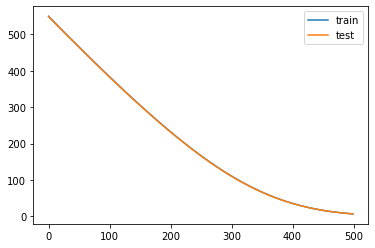

In [33]:
ep=500
plt.plot(range(ep),model.history.history["loss"],label="train")
plt.plot(range(ep),model.history.history["val_loss"],label="test")
plt.legend()

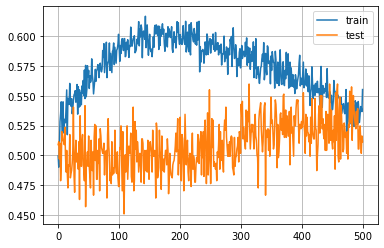

In [34]:
plt.plot(range(ep),model.history.history["acc"],label="train")
plt.plot(range(ep),model.history.history["val_acc"],label="test")
plt.legend()
plt.grid()

## ¿Cómo se ve un filtro probabilístico de la CNN?

### Layers...

Primero, veamos los layers que componen el modelo para identificar cada paso de la arquitectura...

In [36]:
from ipywidgets import interact
plt.style.use("seaborn")
model.layers

Como podemos ver el layer 3 representa el paso de la red convolucional 1D por tanto lo que debemos hacer es toamr 1 layer antes para ver el output del layer 2 qu es el input de nuestra CNN y así poder mostar el detalle de lo que hace el flipout de la neurona...

In [37]:
lay1out=[layer.output for layer in model.layers[1:3]]
act2mod=Model(model.input,lay1out)
pred2=np.array(act2mod.predict(xx_test[0:1])[-1])
lay1out, pred2.shape

([<tf.Tensor 'batch_normalization/batchnorm/add_1:0' shape=(?, 15, 36) dtype=float32>,
  <tf.Tensor 'gaussian_noise/cond/Merge:0' shape=(?, 15, 36) dtype=float32>],
 (1, 15, 36))

Después de aplicar la normalización Batch+ agregar ruido con el gaussianNoise tenemos un output de 15X36 que es el primer elemento del test.

### ¿Cómo se construye el output de la CNN Bayesiana? 

Usando el output anterior vamos a aplicar los filtros de la CNN recordar que es una vista probabilística entonces los pesos no son determinísticos más bien son distribuciones y eso como se ve en los layers, i. e. $w \sim \mathcal{N}(\mu,\sigma^2)$

**Primero, mostramos el resultado al que debemos llegar y luego vamos desmenuzar el método mediante el cual se llega al resultado...**

In [38]:
#pred2[0,0,0]

In [39]:
#hacemos el modelo parcial para ver el resultado al que queremos llegar
lay2out=[layer.output for layer in model.layers[1:4]]
act3mod=Model(model.input,lay2out)


In [44]:
#model.layers[3].get_weights()

In [41]:
pred3=np.array(act3mod.predict(xx_test[0:1])[-1])
pred3.shape#[0,0,0]

(1, 15, 128)

#### ¿Por qué tenemos este resultado?

Recordar que tenemos 128 filtros aplicados a una matriz de 15 x 36 que son las dimensiones del input y como pedimos que las convoluciones con los filtros(filtros son de tamaño 10) se pasen el número de veces de las dimensiones del aooutput (esto pasa cuando hacemos padding="same") entonces al pasar el fultro tenemos 15 outputs en cada uno de los 128 filtros por tanto la dimensión de la salida, ahora cada entrada de este output NO es un número o resultado determinístico  es una distribución!!

Vamos a identificar los pesos de la CNN y que significa cada salida, tenemso 4 elementos como output del método get_weights, el primero son las medias $\mu's$ y el segundo son las $\sigma's$ pero ojo estas  últimas con el truco de la reparametrización i. e.  para obtener la $\sigma$ hay que aplicar $$f(\sigma)=\ln \left(1+e^{\sigma}\right)$$ y finalmente el 3er elemento es el vector de biases..

In [46]:
#obteniendo los pesos del primer filtro, en el primer elemento y primera columna.
#tenemos 4 elementos en model.layers[3].get_weights(), el primero son las medias, el sugundo son las desviaciones std con softplus
# la tercera son los biases.
mu,sig,b=model.layers[3].get_weights()[0][0,0,0],tf.Session().run(tf.nn.softplus(model.layers[3].get_weights()[1][0,0,0])),model.layers[3].get_weights()[2][0]

In [47]:
#Hacemos el input de la CNN con paddings añadiendo 0's...
yi=pred2.reshape(15,36)
yipad=np.vstack((np.vstack((np.zeros((4,36)),yi)),np.zeros((5,36))))
yipad.shape

(24, 36)

In [48]:
#parámetros del primer elemento de los pesos 
mu,sig,b

(0.0139369415, 0.8860105, 0.0124390945)

Recordar que los pesos NO son las $w's$ direcatementa dado que estamos trabajando con distribuciones los primeros 2 elementos de del método de pesos de la CNN son los parámetros $(\mu_{0},\sigma_{0})$ que representan la distribución Normal posterior del layer por tanto el peso del primer elemento por ejemplo es una $w_{0} \sim \mathcal{N}(\mu_{0},\sigma^2_{0})$

In [49]:
#obtenemos los elementos d elos pesos por separado...
filters,sigs,biases,_ = model.layers[3].get_weights()

In [50]:
#Hacemos la función de activación from scratch...
def likirelu(x,alfa):
    if x<0:
        sal=alfa*x
        return(sal)
    else:
        return(x)

In [51]:
#likirelu(np.sum(filters[:,:,0]*yipad[0:10,:])+biases[0],.1)

Resultado del primer elemento después de pasar el primer filtro de la CNN...

In [53]:
%%time
prd3=[]
for k in range(5000):
    pron=np.array(act3mod.predict(xx_test[0:1])[-1])[0,0,0]
    prd3.append(pron)

Wall time: 14 s


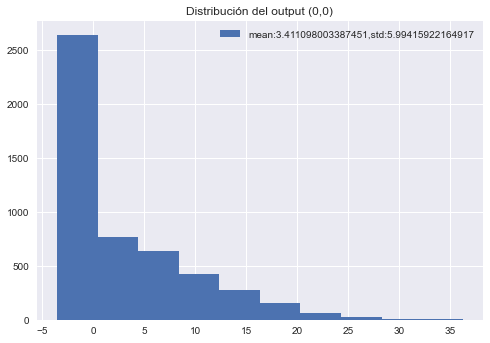

In [56]:
plt.hist(prd3,label=f"mean:{np.mean(prd3)},std:{np.std(prd3)}")
plt.legend()
plt.title("Distribución del output (0,0)")
plt.show()

#### ¿ Y cómo llego a esta distribución a partir de los pesos?

Primero veamos la distribución de todos los pesos  del primer filtro, recordar que nuestros filtros son de tamaño 10 x 36, 10 del filtro y 36 variables que tenemos por tanto en cada filtro hay 360 distribuciones que corresponde a cada peso, por ejemplo si vemos la distribución del primer filtro en el primer elemmento en la 1ra. variable tenemos:

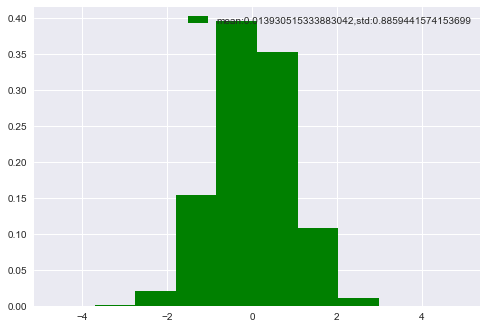

0.0139369415 0.8860105


In [57]:
w0=np.random.normal(mu,sig,5000000)
plt.hist(w0,label=f"mean:{np.mean(w0)},std:{np.std(w0)}",color="g",density=True)
plt.legend()
plt.show()
print(mu,sig)

In [58]:
#Ejemplo de como se muestrea un elemento de cada distribución del primer filtro
#ojo: [:,:,0] matriz de medias, de desviaciones 
np.random.normal(model.layers[3].get_weights()[0][:,:,0],tf.Session().run(tf.nn.softplus(model.layers[3].get_weights()[1][:,:,0]))).shape

(10, 36)

In [59]:
def hazfiltros(layer):
    """
    Función que genera una muestra de cada una de las 10X36 dstribuciones contenidas en el 1er filtro.
    input:
          layer: objeto neurona a revisar
          
    output:
          una matriz de 10 X 36
    """
    sal=np.random.normal(layer.get_weights()[0][:,:,0],tf.Session().run(tf.nn.softplus(layer.get_weights()[1][:,:,0])))
    return(sal)
hazfiltros(model.layers[3]).shape

(10, 36)

In [61]:
#np.sum(np.tile(hazfiltros(model.layers[3]),(5000,1,1))*np.tile(yipad[0:10,:],(5000,1,1)),axis=(1,2))

##### Comprobación de método

In [63]:
%%time
#hacemos 1000 muestras de las distribuciones del primer filtro para poder crear una distribución del output
misfilt=np.array([hazfiltros(model.layers[3]) for _ in range(1000)])

Wall time: 2min 42s


In [64]:
misfilt.shape

(1000, 10, 36)

Hacemos 1000 veces $$(f * g)[n]=\sum_{m=-\infty}^{\infty} f[m] g[n-m]$$ cada una de estas convoluciones es un dato que nos ayuda a crear la distribución del elemento (0,0) del output que obtuvimoscon act3mod y guardamos en pred3...

In [78]:
#Coma
ejems=np.sum(misfilt*np.tile(yipad[0:10,:],(1000,1,1)),axis=(1,2))+biases[0]
ejemres=np.array([likirelu(x,.1) for x in ejems])

Text(0.5, 1.0, 'Distribución del output usando los filtros de CNN')

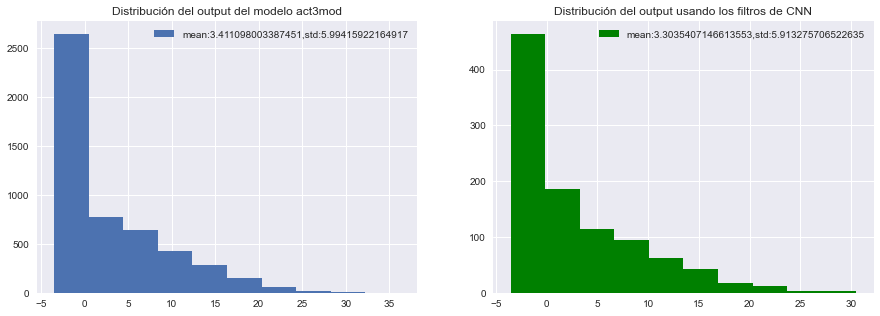

In [81]:
#comparamos el resultado con el modelo act3mod vs. haciendo uso de los pesos para mostrar como se llega a lo mismo...
fig,ax=plt.subplots(1,2, figsize=(15,5))
ax[0].hist(prd3,label=f"mean:{np.mean(prd3)},std:{np.std(prd3)}")
ax[0].legend()
ax[0].set_title("Distribución del output del modelo act3mod")
ax[1].hist(ejemres,label=f"mean:{np.mean(ejemres)},std:{np.std(ejemres)}",color="green")
ax[1].legend()
ax[1].set_title("Distribución del output usando los filtros de CNN")

Hemos probado que tenemos la misma distribución.

#### visualización de filtros

In [252]:
def grafilt(layer,i):
    """
    Función que genera una muestra de cada una de las 10X36X128 dstribuciones contenidas en los filtros.
    input:
          layer: objeto neurona a revisar
          i: número de filtro que se quiere ver
          
    output:
          una matriz de 10 X 36
    """    
    
    sal=np.random.normal(layer.get_weights()[0][:,:,i],tf.Session().run(tf.nn.softplus(layer.get_weights()[1][:,:,i])))
    return(sal)
grafilt(model.layers[3],123).shape

(10, 36)

In [253]:
#np.random.normal(filters[0,0,20],tf.Session().run(tf.nn.softplus(sigs[0,0,20])),5000)

array([-0.24014488,  0.4210613 , -1.42363784, ..., -0.54570543,
        0.40720667,  0.76247619])

##### Mostrando Filtros interactivos

In [82]:
%%time
from ipywidgets import interact
plt.style.use("seaborn")
def filtro_n(num):
    plt.title(f"Filtro:{num}")
    # plot first few filters
    tam_filters, ix = 10, 1
    for i in range(tam_filters):
        # get the filter
        #f = grafilt(model.layers[2],num)[i,:]
        # plot each channel separately
        for j in range(36):
            #fig = plt.figure(figsize=(58,5))
            # specify subplot and turn of axis

            ax = plt.subplot(tam_filters, 36, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            #ax.set_xlim(-10,10)

            # plot filter channel in grayscale 
            ax.hist(np.random.normal(filters[i,j,num],tf.Session().run(tf.nn.softplus(sigs[i,j,num])),5000), color="g")
    
            ix += 1
    
    # show the figure
    plt.show()
interact(filtro_n,num=np.arange(0,128))  

interactive(children=(Dropdown(description='num', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

Wall time: 1min 5s


<function __main__.filtro_n(num)>

#### Replicando el gráfico(lado derecho)

![texto alternativo](https://miro.medium.com/max/1050/1*_OKFNjh-GUl0Kl4cND5Djw.png)

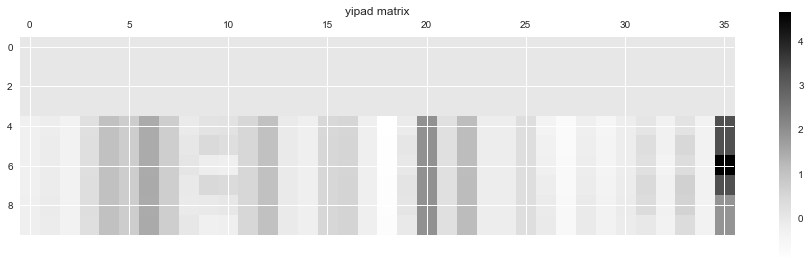

In [91]:
plt.matshow(yipad[0:10,:])
plt.colorbar()
plt.title("yipad matrix")
plt.show()

**Replica**

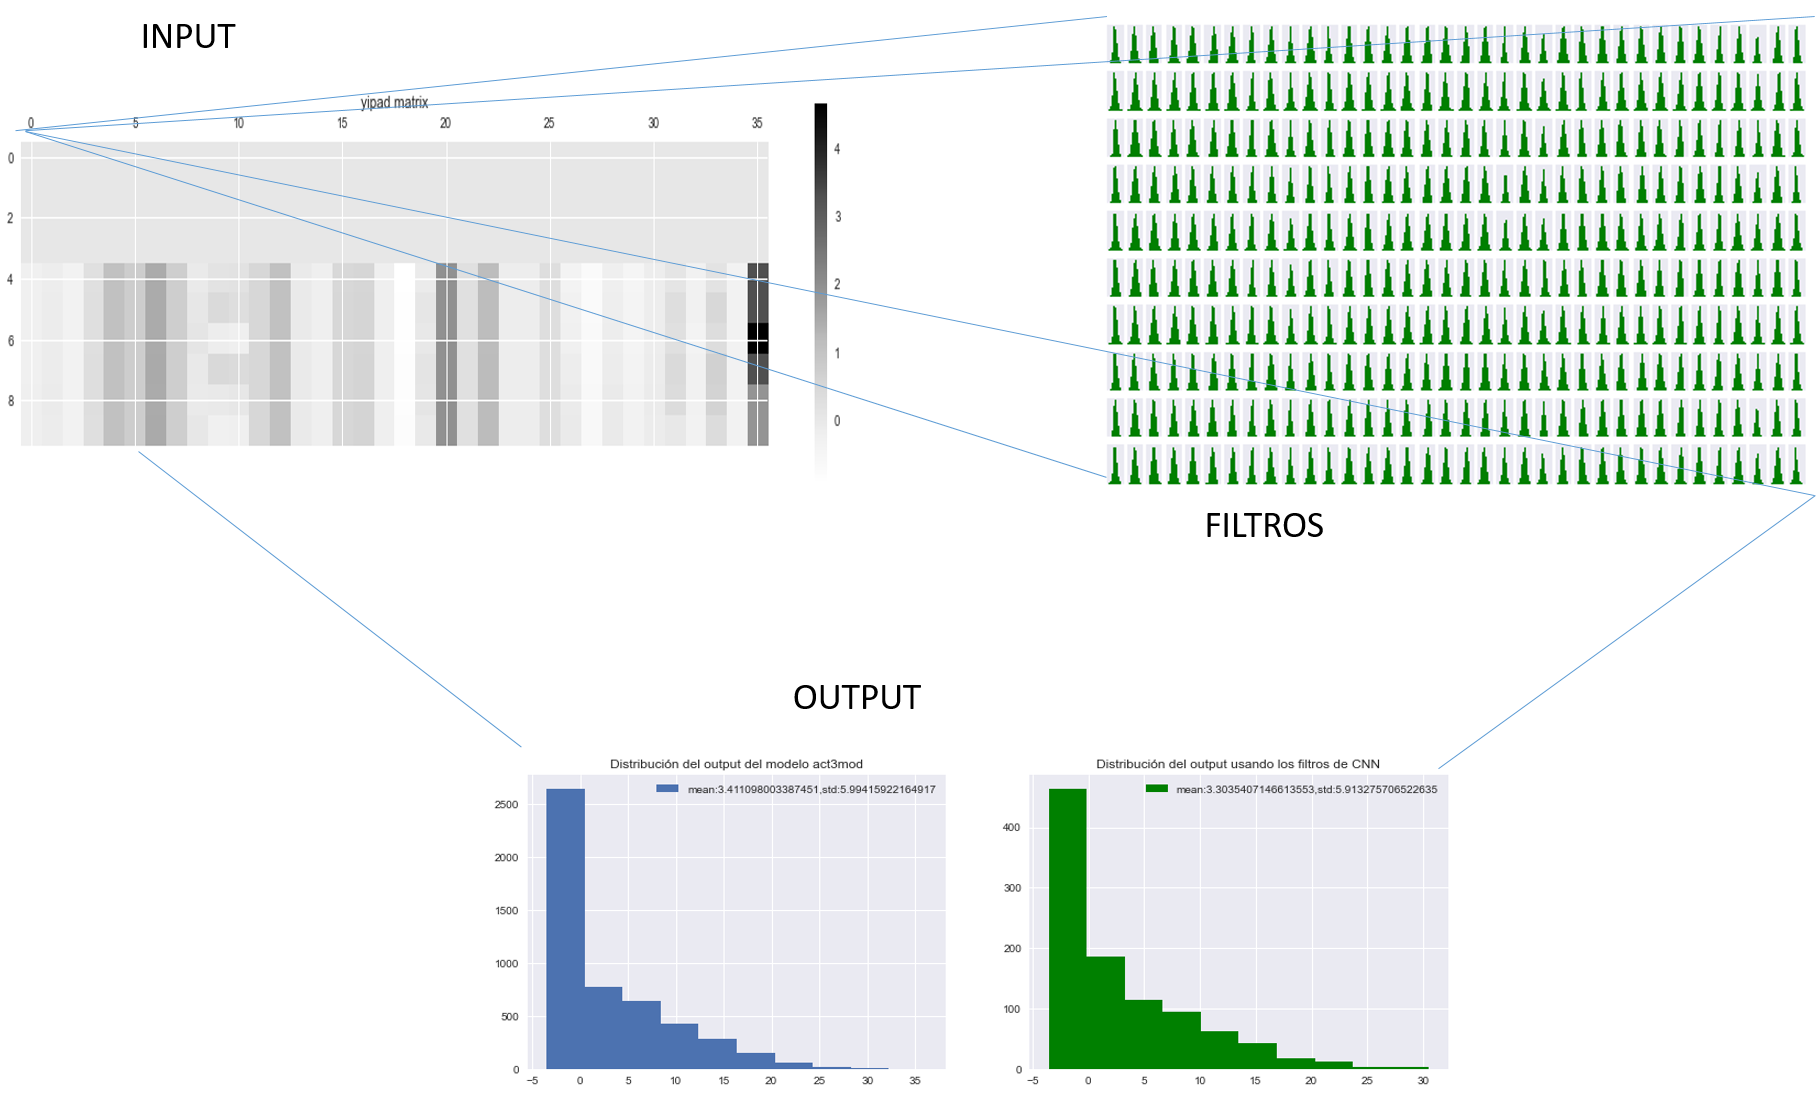

In [92]:
from IPython.display import Image
Image(filename='C:/Users/Abraham/Documents/cNN1D.png')

Así replicamos la infografía, no se replican todos los outputs dado el tamaño del proceso!!

Ahora como se ven las dimensiones de cada layer en cada paso de la arquitectura del modelo.

In [99]:
#w=tf.Session().run(tfp.distributions.Normal(loc=model.layers[3].get_weights()[0][4,0,0], scale=tf.Session().run(tf.nn.softplus(model.layers[3].get_weights()[1][4,0,0]))).sample(1))
#sig=tf.Session().run(tf.nn.softplus(model.layers[3].get_weights()[1][4,0,0]))
#plt.hist(np.tile(w*pred2[0,0,0]+model.layers[3].get_weights()[2][0],5000))
for j in range(len(model.get_weights())):
    print(model.get_weights()[j].shape)

(36,)
(36,)
(36,)
(36,)
(10, 36, 128)
(10, 36, 128)
(128,)
()
(128,)
(128,)
(128,)
(128,)
(256,)
(256,)
(256,)
(256,)
(256, 200)
(256, 200)
(200,)
()
(200,)
(200,)
(200,)
(200,)
(200, 2)
(200, 2)
(2,)
()


## Fully conected layers Probabilístico

Primero obtenemos el input...

In [106]:
model.layers[1:8]

In [107]:
lay7out=[layer.output for layer in model.layers[1:8]]
act7mod=Model(model.input,lay7out)
pred7=np.array(act7mod.predict(xx_test[0:1])[-1])
lay7out, pred7.shape

([<tf.Tensor 'batch_normalization/batchnorm/add_1:0' shape=(?, 15, 36) dtype=float32>,
  <tf.Tensor 'gaussian_noise/cond/Merge:0' shape=(?, 15, 36) dtype=float32>,
  <tf.Tensor 'conv1d_flipout/leaky_re_lu/LeakyRelu:0' shape=(?, 15, 128) dtype=float32>,
  <tf.Tensor 'batch_normalization_1/batchnorm/add_1:0' shape=(?, 15, 128) dtype=float32>,
  <tf.Tensor 'max_pooling1d/Squeeze:0' shape=(?, 2, 128) dtype=float32>,
  <tf.Tensor 'flatten/Reshape:0' shape=(?, 256) dtype=float32>,
  <tf.Tensor 'batch_normalization_2/batchnorm/add_1:0' shape=(?, 256) dtype=float32>],
 (1, 256))

Tenemos un input de 256 entradas entonces ahora para ver el output del primer denseflipout layer...

### Resultado esperado

In [108]:
lay8out=[layer.output for layer in model.layers[1:9]]
act8mod=Model(model.input,lay8out)
pred8=np.array(act8mod.predict(xx_test[0:1])[-1])
lay8out, pred8.shape

([<tf.Tensor 'batch_normalization/batchnorm/add_1:0' shape=(?, 15, 36) dtype=float32>,
  <tf.Tensor 'gaussian_noise/cond/Merge:0' shape=(?, 15, 36) dtype=float32>,
  <tf.Tensor 'conv1d_flipout/leaky_re_lu/LeakyRelu:0' shape=(?, 15, 128) dtype=float32>,
  <tf.Tensor 'batch_normalization_1/batchnorm/add_1:0' shape=(?, 15, 128) dtype=float32>,
  <tf.Tensor 'max_pooling1d/Squeeze:0' shape=(?, 2, 128) dtype=float32>,
  <tf.Tensor 'flatten/Reshape:0' shape=(?, 256) dtype=float32>,
  <tf.Tensor 'batch_normalization_2/batchnorm/add_1:0' shape=(?, 256) dtype=float32>,
  <tf.Tensor 'dense_flipout/Tanh:0' shape=(?, 200) dtype=float32>],
 (1, 200))

### Distribución primer output layer

In [119]:
%%time
prd8=[]
for k in range(5000):
    pron8=np.array(act8mod.predict(xx_test[0:1])[-1])[0,0]
    prd8.append(pron8)

Wall time: 18.4 s


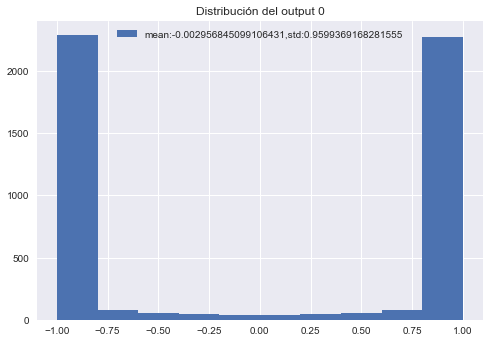

In [121]:
plt.hist(prd8,label=f"mean:{np.mean(prd8)},std:{np.std(prd8)}")
plt.legend()
plt.title("Distribución del output 0")
plt.show()

### ¿Cómo llego a esta distribución?

In [133]:
#pesos w's
np.dot(pred7[0,:],model.layers[8].get_weights()[0][:,0])+model.layers[8].get_weights()[0]

0.18930979

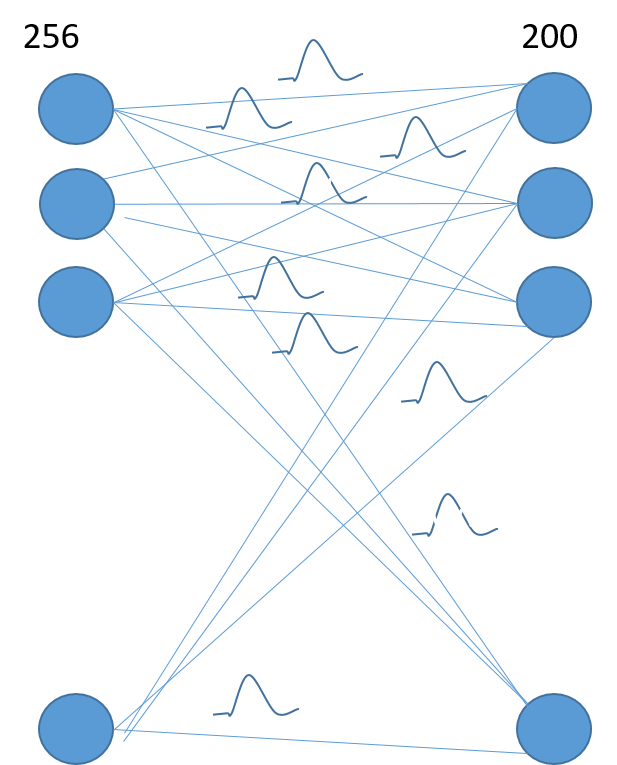

In [147]:
Image(filename='C:/Users/Abraham/Documents/w200.png')

Recordar: $$Z=XW+b$$ con $$X \in  \mathbb{R}^{256}, W \in \mathbb{R}^{256 x 200}, b \in \mathbb{R}^{200}$$

In [134]:
def hazdis(layer):
    """
    Función que genera una muestra de cada una de las 256 dstribuciones contenidas en el 1er filtro.
    input:
          layer: objeto neurona a revisar
          
    output:
          una matriz de 256
    """
    sal=np.random.normal(layer.get_weights()[0][:,0],tf.Session().run(tf.nn.softplus(layer.get_weights()[1][:,0])))
    return(sal)
hazdis(model.layers[8]).shape

(256,)

In [135]:
%%time
#hacemos 1000 muestras de las distribuciones del primer filtro para poder crear una distribución del output
misdist=np.array([hazdis(model.layers[8]) for _ in range(1000)])

Wall time: 4min 39s


In [137]:
misdist.shape,pred7.shape

((1000, 256), (1, 256))

In [145]:
aux=np.dot(misdist,pred7.T)+model.layers[8].get_weights()[2][0]
auxdis=np.array([np.tanh(x) for x in aux])

Text(0.5, 1.0, 'Distribución del output usando los pesos W')

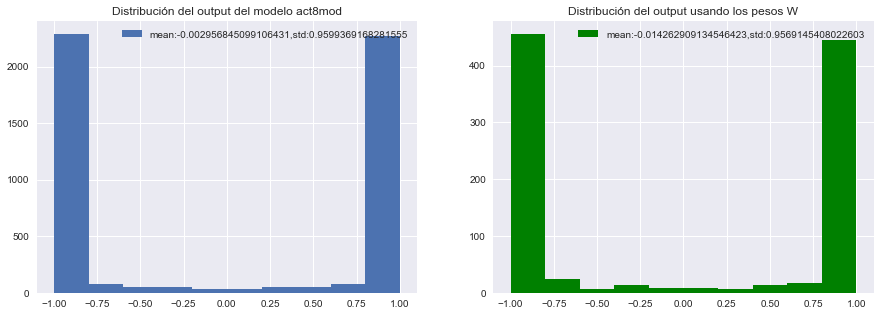

In [146]:
#comparamos el resultado con el modelo act3mod vs. haciendo uso de los pesos para mostrar como se llega a lo mismo...
fig,ax=plt.subplots(1,2, figsize=(15,5))
ax[0].hist(prd8,label=f"mean:{np.mean(prd8)},std:{np.std(prd8)}")
ax[0].legend()
ax[0].set_title("Distribución del output del modelo act8mod")
ax[1].hist(auxdis,label=f"mean:{np.mean(auxdis)},std:{np.std(auxdis)}",color="green")
ax[1].legend()
ax[1].set_title("Distribución del output usando los pesos W")

### Visualización de distribuciones de los pesos $W's$

In [148]:
meds,ros,bs,_=model.layers[8].get_weights()

In [175]:
#ros

In [180]:
%%time
def dis_n(feature,dist):
    """
    Función que grafica la distribución w[i,j] (con 50 mill de muestras) el i-ésimo feature y j-ésimo output
    
    input:
         int feature.- i-ésimo feature de entrada
         int dist.- j-ésimo output 
    output:
          Histograma de distribución
    """
    mu=meds[feature,dist]
    rox=tf.Session().run(tf.nn.softplus(ros[feature,dist]))
    
    params=np.random.normal(mu,rox,50000000)
    plt.hist(params,label=f"mean:{np.mean(params)},std:{np.std(params)}", color="g",density=True)
    plt.legend()
    plt.title(r"$w_{feature,dist} \sim \mathcal{N}$"+"("+str(mu)+","+str(rox)+")")
    plt.show()
    
interact(dis_n,feature=(0,257),dist=(0,201))    

interactive(children=(IntSlider(value=128, description='feature', max=257), IntSlider(value=100, description='…

Wall time: 3.14 s


<function __main__.dis_n(feature, dist)>

## Resultados Modelo

**Con lo mostrado en esta sección 3 se puede entender porque al usal el modelo sobre el mismo input se obtienen resultados distintos desde el punto de vista determinístico pero en realidad el output es una distribución y cada predicción es una muestra de ella y claro esa es la diferencia de hacer un modelo que mide la incertidumbre que en este caso es lo que se construyó y es así xq cada corrida se muestrean de las distribuciones de cada peso tanto de la CNN como de las dense layers entonces esas combinaciones muestreadas muchas veces crean la distribución final.**

### Distribución por clase...

Wall time: 3min 9s


Text(0.5, 1.0, 'Distribución de predicción clase 1, real:1')

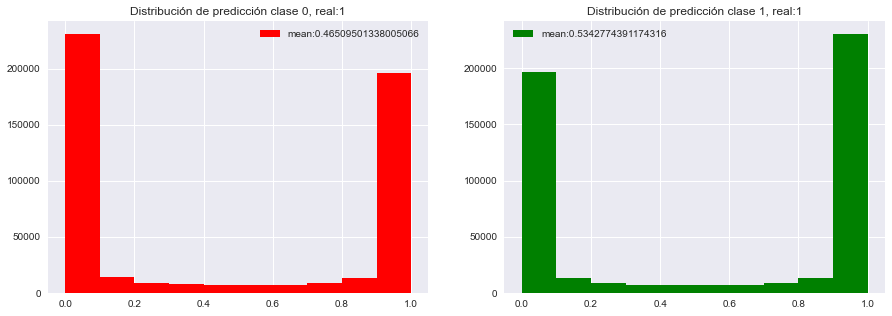

In [183]:
%%time
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].hist(model.predict(np.tile(xx_test[50],(500000,1,1)))[:,0],label=f"mean:{np.mean(model.predict(np.tile(xx_test[50],(500000,1,1)))[:,0])}",color="r")
ax[0].legend()
ax[0].set_title("Distribución de predicción clase 0, real:"+str(yy_test[50]))
ax[1].hist(model.predict(np.tile(xx_test[50],(500000,1,1)))[:,1],label=f"mean:{np.mean(model.predict(np.tile(xx_test[50],(500000,1,1)))[:,1])}",color="g")
ax[1].legend()
ax[1].set_title("Distribución de predicción clase 1, real:"+str(yy_test[50]))

In [187]:
%%time
def restest(i):
    
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    ax[0].hist(model.predict(np.tile(xx_test[i],(500000,1,1)))[:,0],label=f"mean:{np.mean(model.predict(np.tile(xx_test[i],(500000,1,1)))[:,0])}",color="r")
    ax[0].legend()
    ax[0].set_title("Distribución de predicción clase 0, real:"+str(yy_test[i]))
    ax[1].hist(model.predict(np.tile(xx_test[i],(500000,1,1)))[:,1],label=f"mean:{np.mean(model.predict(np.tile(xx_test[i],(500000,1,1)))[:,1])}",color="g")
    ax[1].legend()
    ax[1].set_title("Distribución de predicción clase 1, real:"+str(yy_test[i]))

interact(restest,i=(0,len(xx_test)))    

interactive(children=(IntSlider(value=413, description='i', max=827), Output()), _dom_classes=('widget-interac…

Wall time: 3min 15s


<function __main__.restest(i)>